# Q4 – MMM01 vs MMM02 (Mean-Reversion Market Maker) in Synthetic and Nasdaq Markets

This notebook implements Question 4 of the INFT coursework.

We compare:
- **MMM01**: baseline market-maker (from Q3)
- **MMM02**: modified *mean-reversion* market-maker

under **strictly controlled conditions**:
- same synthetic CDA market as in Q3
- same Nasdaq-offset market as in Q3 (offset-nasdaq-1m-170913.csv)
- same trader population (ZIC, ZIP, SHVR, SNPR, PRZI, plus one market-maker)
- same MMM parameters (n_past_trades, bid_percent, ask_delta) for both MMM01 and MMM02
- same session length and random seeds per market/run

The only difference between the two treatments is the **market-maker algorithm**.


In [1]:
import os
import csv
import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import BSE
from BSE import offset_from_file  # used for the Nasdaq-based offset schedule

BASE_SEED = 310
Q4DATA_DIR = "Q4data"
os.makedirs(Q4DATA_DIR, exist_ok=True)

# tqdm for progress bars
try:
    from tqdm.notebook import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

# Session timing (same as Q3)
START_TIME = 0
END_TIME = 60 * 15  

print("Imports OK, data dir:", Q4DATA_DIR)


Imports OK, data dir: Q4data


## Parameter block: MMM01* configuration, markets, and IID runs

- `MMM_PARAMS` should be set to the **best-performing MMM01* configuration from Q3**.
- `MARKET_IDS` should list:
  - one synthetic CDA market (same as your main synthetic market in Q3)
  - one Nasdaq-based offset market (e.g., using `offset-nasdaq-1m-170913`).
- The number of IID runs per market should be large enough (e.g. 30–50) for hypothesis testing.
- The trader population (other trader types, numbers) should match your Q3 setup, except
  that we switch between MMM01 and MMM02.


In [2]:
MMM_PARAMS = {
    "n_past_trades": 7,    
    "bid_percent": 0.97,
    "ask_delta": 10,
}

# Markets to test (controlled to match Q3)
MARKETS = ["synthetic", "nasdaq"]

# IID runs per market per MM version (adjust if runtime is too long)
N_RUNS_PER_MARKET = 30  # e.g. 30 or 50 runs

print("MMM parameters:", MMM_PARAMS)
print("Markets:", MARKETS)
print("Runs per market:", N_RUNS_PER_MARKET)


MMM parameters: {'n_past_trades': 7, 'bid_percent': 0.97, 'ask_delta': 10}
Markets: ['synthetic', 'nasdaq']
Runs per market: 30


In [3]:
# ---------- Synthetic market (same as Q3) ----------

def make_virtual_order_schedule(start_time=START_TIME, end_time=END_TIME):
    """
    Synthetic CDA market: random supply and demand ranges with overlap.
    This matches the Q3 synthetic configuration.
    """
    sup_range = (150, 200)
    dem_range = (170, 220)

    supply_schedule = [{
        "from": start_time,
        "to": end_time,
        "ranges": [sup_range],
        "stepmode": "random",
    }]
    demand_schedule = [{
        "from": start_time,
        "to": end_time,
        "ranges": [dem_range],
        "stepmode": "random",
    }]

    order_sched = {
        "sup": supply_schedule,
        "dem": demand_schedule,
        "interval": 30,
        "timemode": "drip-jitter",
    }
    return order_sched


# ---------- Nasdaq-offset market (same as Q3) ----------

NASDAQ_CSV_PATH = "offset-nasdaq-1m-170913.csv"
TIME_COL = 1    
PRICE_COL = 5   
SCALE_FACTOR = 75.0  
def build_nasdaq_offset(end_time=END_TIME):
    """
    Build a time-dependent price offset from the Nasdaq 1-minute data.
    """
    offset_fn = offset_from_file(
        price_offset_filename=NASDAQ_CSV_PATH,
        time_col=TIME_COL,
        price_col=PRICE_COL,
        scale_factor=SCALE_FACTOR,
        end_time=end_time,
    )
    return offset_fn

nasdaq_offset = build_nasdaq_offset()

def make_nasdaq_order_schedule(offset, start_time=START_TIME, end_time=END_TIME):
    """
    Nasdaq-based CDA market: base ranges shifted by a time-varying offset.
    This matches the Q3 Nasdaq configuration.
    """
    # overlap of supply & demand (base ranges before offset)
    base_sup_range = (120, 220)
    base_dem_range = (180, 280)

    sup_range = (base_sup_range[0], base_sup_range[1], offset)
    dem_range = (base_dem_range[0], base_dem_range[1], offset)

    supply_schedule = [{
        "from": start_time,
        "to": end_time,
        "ranges": [sup_range],
        "stepmode": "random",
    }]
    demand_schedule = [{
        "from": start_time,
        "to": end_time,
        "ranges": [dem_range],
        "stepmode": "random",
    }]

    order_sched = {
        "sup": supply_schedule,
        "dem": demand_schedule,
        "interval": 10,
        "timemode": "drip-jitter",
    }
    return order_sched


# ---------- Seeds: keep random structure controlled (matching Q3 pattern) ----------

def get_seed(market_id, run_id):
    """
    Returns a deterministic random seed for each (market_id, run_id).
    We follow the same structure as in Q3, so the environment is comparable.
    """
    if market_id == "synthetic":
        return BASE_SEED + run_id
    elif market_id == "nasdaq":
        return BASE_SEED + 10_000 + run_id
    else:
        raise ValueError(f"Unknown market_id: {market_id}")


In [4]:
def make_traders_spec(mm_version, mmm_params, n_each_type=5):
    trader_types_simple = ["ZIC", "ZIP", "SHVR", "SNPR"]
    buyers_spec = []
    sellers_spec = []

    # symmetric simple traders
    for t in trader_types_simple:
        buyers_spec.append((t, n_each_type))
        sellers_spec.append((t, n_each_type))

    # PRZI parameters (same for buyers and sellers)
    przi_params = {
        "s_min": -1.0,
        "s_max": 1.0,
        "k": 1,
    }
    buyers_spec.append(("PRZI", n_each_type, przi_params))
    sellers_spec.append(("PRZI", n_each_type, przi_params))

    # market-maker: either MMM01 or MMM02
    if mm_version not in ["MMM01", "MMM02"]:
        raise ValueError(f"mm_version must be 'MMM01' or 'MMM02', got {mm_version}")

    mrktmakers_spec = [(mm_version, 1, mmm_params)]

    return {
        "buyers": buyers_spec,
        "sellers": sellers_spec,
        "mrktmakers": mrktmakers_spec,
    }


In [5]:
def get_mm_realized_profit_from_blotter(blotter_path, mmm_tid="M00"):
    """
    Compute the realised profit for the market-maker from a blotter CSV.

    Simple convention:
    - read all trade prices executed by the MM (tid == mmm_tid)
    - group prices in buy/sell pairs in chronological order
    - profit = sum (sell_price - buy_price) over pairs

    This matches the profit measure used in Q3.
    """
    if not os.path.exists(blotter_path):
        return 0.0

    prices = []
    with open(blotter_path, newline="") as f:
        reader = csv.reader(f)
        rows = list(reader)

    i = 0
    while i < len(rows):
        row = rows[i]
        if not row:
            i += 1
            continue
        tid = row[0].strip()
        if tid == mmm_tid:
            # row format: tid, n_trades, ...
            try:
                n_trades = int(row[1])
            except (ValueError, IndexError):
                n_trades = 0
            for j in range(i + 1, i + 1 + n_trades):
                if j >= len(rows):
                    break
                trade_row = rows[j]
                if len(trade_row) < 4:
                    continue
                # price is in column 4 (index 3)
                try:
                    price = float(trade_row[3])
                except ValueError:
                    continue
                prices.append(price)
            i += 1 + n_trades
        else:
            # skip trades for other traders
            try:
                n_trades = int(row[1])
            except (ValueError, IndexError):
                n_trades = 0
            i += 1 + n_trades

    n_pairs = len(prices) // 2
    profit = 0.0
    for k in range(n_pairs):
        buy_price = prices[2 * k]
        sell_price = prices[2 * k + 1]
        profit += (sell_price - buy_price)

    return profit


In [6]:
DUMP_FLAGS_Q4 = {
    "dump_blotters": True,
    "dump_lobs": False,
    "dump_strats": False,
    "dump_avgbals": False,
    "dump_tape": False,
}

def run_single_experiment(market_id, mm_version, mmm_params, run_id, verbose=False):
    """
    Run a single market_session for a given market and MM version.

    - market_id: 'synthetic' or 'nasdaq'
    - mm_version: 'MMM01' or 'MMM02'
    - mmm_params: dict with keys n_past_trades, bid_percent, ask_delta
    - run_id: integer index for IID runs

    Returns:
    - realised profit of the market-maker in this run
    """
    # session label for output files
    sess_label = (
        f"Q4_{market_id}_{mm_version}_"
        f"n{mmm_params['n_past_trades']}_"
        f"bp{mmm_params['bid_percent']:.2f}_"
        f"ad{mmm_params['ask_delta']}_"
        f"run{run_id:03d}"
    )
    sess_id = os.path.join(Q4DATA_DIR, sess_label)
    os.makedirs(os.path.dirname(sess_id), exist_ok=True)

    # seed the RNG in BSE to keep the environment controlled
    seed = get_seed(market_id, run_id)
    BSE.random.seed(seed)

    # trader population (same for both MMM versions)
    traders_spec = make_traders_spec(mm_version=mm_version, mmm_params=mmm_params, n_each_type=5)

    # market configuration (same as Q3)
    if market_id == "synthetic":
        order_sched = make_virtual_order_schedule(START_TIME, END_TIME)
    elif market_id == "nasdaq":
        order_sched = make_nasdaq_order_schedule(nasdaq_offset, START_TIME, END_TIME)
    else:
        raise ValueError(f"Unknown market_id: {market_id}")

    if verbose:
        print(f"Running session: {sess_id}")

    # run the market session
    BSE.market_session(
        sess_id,
        START_TIME,
        END_TIME,
        traders_spec,
        order_sched,
        DUMP_FLAGS_Q4,
        sess_vrbs=False,
    )

    # extract MM profit
    blotter_path = sess_id + "_blotters.csv"
    profit = get_mm_realized_profit_from_blotter(blotter_path, mmm_tid="M00")

    return profit


In [7]:
def run_experiments_for_mm(mm_version, mmm_params, markets, n_runs_per_market):
    """
    Run multiple IID experiments for a given MM version across all markets.

    Returns:
    - pandas DataFrame with columns:
      ['market_id', 'trader_type', 'mm_version', 'run_id', 'profit']
    """
    results = []

    for market_id in markets:
        iterator = range(n_runs_per_market)
        iterator = tqdm(iterator, desc=f"{market_id} / {mm_version}", leave=False)

        for run_id in iterator:
            profit = run_single_experiment(
                market_id=market_id,
                mm_version=mm_version,
                mmm_params=mmm_params,
                run_id=run_id,
                verbose=False,
            )
            results.append({
                "market_id": market_id,
                "trader_type": "market_maker",
                "mm_version": mm_version,
                "run_id": run_id,
                "profit": profit,
            })

    results_df = pd.DataFrame(results)
    return results_df


In [8]:
# Run experiments for MMM01 (baseline) and MMM02 (mean-reversion)
mmm01_results_df = run_experiments_for_mm(
    mm_version="MMM01",
    mmm_params=MMM_PARAMS,
    markets=MARKETS,
    n_runs_per_market=N_RUNS_PER_MARKET,
)

mmm02_results_df = run_experiments_for_mm(
    mm_version="MMM02",
    mmm_params=MMM_PARAMS,
    markets=MARKETS,
    n_runs_per_market=N_RUNS_PER_MARKET,
)

all_results_df = pd.concat([mmm01_results_df, mmm02_results_df], ignore_index=True)

print("Number of observations:", len(all_results_df))
all_results_df.head()


synthetic / MMM01:   0%|          | 0/30 [00:00<?, ?it/s]

MM01 init: n_past_trades=7, bid_percent=0.97000, ask_delta=10

t=309.098039 (0h05m09s) M00 (MMM01) bookkeep: orders=[M00 Bid P=178 Q=1 T=300.45 QID:5239] Balance=322 NetWorth=500
t=386.392157 (0h06m26s) M00 (MMM01) bookkeep: orders=[M00 Ask P=188 Q=1 T=386.37 QID:6743] Balance=511 NetWorth=511
t=437.176471 (0h07m17s) M00 (MMM01) bookkeep: orders=[M00 Bid P=185 Q=1 T=437.16 QID:7668] Balance=327 NetWorth=511
t=478.333333 (0h07m58s) M00 (MMM01) bookkeep: orders=[M00 Ask P=194 Q=1 T=478.31 QID:8535] Balance=527 NetWorth=527
t=482.960784 (0h08m02s) M00 (MMM01) bookkeep: orders=[M00 Bid P=179 Q=1 T=482.94 QID:8627] Balance=349 NetWorth=527
t=530.294118 (0h08m50s) M00 (MMM01) bookkeep: orders=[M00 Ask P=188 Q=1 T=502.71 QID:8943] Balance=537 NetWorth=537
t=613.764706 (0h10m13s) M00 (MMM01) bookkeep: orders=[M00 Bid P=180 Q=1 T=601.31 QID:10850] Balance=357 NetWorth=537
t=629.921569 (0h10m29s) M00 (MMM01) bookkeep: orders=[M00 Ask P=190 Q=1 T=629.86 QID:11247] Balance=549 NetWorth=549
t=637.0

nasdaq / MMM01:   0%|          | 0/30 [00:00<?, ?it/s]

MM01 init: n_past_trades=7, bid_percent=0.97000, ask_delta=10

t=302.627451 (0h05m02s) M00 (MMM01) bookkeep: orders=[M00 Bid P=211 Q=1 T=293.22 QID:5517] Balance=289 NetWorth=500
t=307.745098 (0h05m07s) M00 (MMM01) bookkeep: orders=[M00 Ask P=221 Q=1 T=306.49 QID:5736] Balance=510 NetWorth=510
t=334.588235 (0h05m34s) M00 (MMM01) bookkeep: orders=[M00 Bid P=246 Q=1 T=332.49 QID:6246] Balance=264 NetWorth=510
t=371.392157 (0h06m11s) M00 (MMM01) bookkeep: orders=[M00 Ask P=256 Q=1 T=371.37 QID:6996] Balance=523 NetWorth=523
t=379.313725 (0h06m19s) M00 (MMM01) bookkeep: orders=[M00 Bid P=247 Q=1 T=375.84 QID:7058] Balance=276 NetWorth=523
t=419.411765 (0h06m59s) M00 (MMM01) bookkeep: orders=[M00 Ask P=257 Q=1 T=419.39 QID:7870] Balance=534 NetWorth=534
t=437.333333 (0h07m17s) M00 (MMM01) bookkeep: orders=[M00 Bid P=247 Q=1 T=435.96 QID:8159] Balance=287 NetWorth=534
t=455.019608 (0h07m35s) M00 (MMM01) bookkeep: orders=[M00 Ask P=257 Q=1 T=450.35 QID:8425] Balance=544 NetWorth=544
t=491.843

synthetic / MMM02:   0%|          | 0/30 [00:00<?, ?it/s]

MM02 init: n_past_trades=7, bid_percent=0.97000, ask_delta=10

t=309.098039 (0h05m09s) M00 (MMM02) bookkeep: orders=[M00 Bid P=178 Q=1 T=300.45 QID:5239] Balance=322 NetWorth=500
t=362.156863 (0h06m02s) M00 (MMM02) bookkeep: orders=[M00 Ask P=180 Q=1 T=362.14 QID:6287] Balance=502 NetWorth=502
t=457.882353 (0h07m37s) M00 (MMM02) bookkeep: orders=[M00 Bid P=187 Q=1 T=457.84 QID:7972] Balance=316 NetWorth=502
t=518.000000 (0h08m37s) M00 (MMM02) bookkeep: orders=[M00 Ask P=189 Q=1 T=517.98 QID:8974] Balance=505 NetWorth=505
t=521.117647 (0h08m41s) M00 (MMM02) bookkeep: orders=[M00 Bid P=185 Q=1 T=521.10 QID:9039] Balance=321 NetWorth=505
t=581.980392 (0h09m41s) M00 (MMM02) bookkeep: orders=[M00 Ask P=190 Q=1 T=581.96 QID:10123] Balance=511 NetWorth=511
t=599.254902 (0h09m59s) M00 (MMM02) bookkeep: orders=[M00 Bid P=181 Q=1 T=599.14 QID:10394] Balance=331 NetWorth=511
t=613.607843 (0h10m13s) M00 (MMM02) bookkeep: orders=[M00 Ask P=190 Q=1 T=613.57 QID:10671] Balance=521 NetWorth=521
t=652.

nasdaq / MMM02:   0%|          | 0/30 [00:00<?, ?it/s]

MM02 init: n_past_trades=7, bid_percent=0.97000, ask_delta=10

t=302.627451 (0h05m02s) M00 (MMM02) bookkeep: orders=[M00 Bid P=211 Q=1 T=293.22 QID:5517] Balance=289 NetWorth=500
t=307.745098 (0h05m07s) M00 (MMM02) bookkeep: orders=[M00 Ask P=221 Q=1 T=306.49 QID:5736] Balance=510 NetWorth=510
t=334.588235 (0h05m34s) M00 (MMM02) bookkeep: orders=[M00 Bid P=246 Q=1 T=332.49 QID:6246] Balance=264 NetWorth=510
t=371.392157 (0h06m11s) M00 (MMM02) bookkeep: orders=[M00 Ask P=256 Q=1 T=371.37 QID:6996] Balance=523 NetWorth=523
t=379.313725 (0h06m19s) M00 (MMM02) bookkeep: orders=[M00 Bid P=247 Q=1 T=375.84 QID:7058] Balance=276 NetWorth=523
t=419.411765 (0h06m59s) M00 (MMM02) bookkeep: orders=[M00 Ask P=257 Q=1 T=419.39 QID:7870] Balance=534 NetWorth=534
t=437.333333 (0h07m17s) M00 (MMM02) bookkeep: orders=[M00 Bid P=247 Q=1 T=435.96 QID:8159] Balance=287 NetWorth=534
t=449.764706 (0h07m29s) M00 (MMM02) bookkeep: orders=[M00 Ask P=257 Q=1 T=448.04 QID:8380] Balance=544 NetWorth=544
t=451.196

,market_id,trader_type,mm_version,run_id,profit
0,synthetic,market_maker,MMM01,0,103.0
1,synthetic,market_maker,MMM01,1,61.0
2,synthetic,market_maker,MMM01,2,67.0
3,synthetic,market_maker,MMM01,3,22.0
4,synthetic,market_maker,MMM01,4,76.0


In [9]:
summary_df = (
    all_results_df
    .groupby(["mm_version"])
    .agg(
        mean=("profit", "mean"),
        std=("profit", "std"),
        median=("profit", "median"),
        min=("profit", "min"),
        max=("profit", "max"),
        count=("profit", "count"),
    )
    .reset_index()
)

print("Summary statistics for MM profits (across BOTH markets):")
summary_df


Summary statistics for MM profits (across BOTH markets):


,mm_version,mean,std,median,min,max,count
0,MMM01,141.500000,88.522046,110.5,22.0,378.0,60
1,MMM02,169.616667,111.092432,139.5,0.0,381.0,60


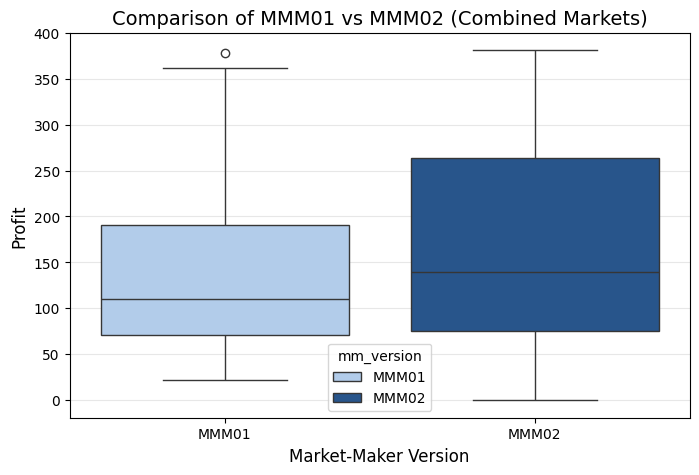

In [10]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=all_results_df,
    x="mm_version",
    y="profit",
    hue="mm_version",                         
    legend=True,                             
    palette=["#A9CBF3", "#17539C"],          
)

plt.title("Comparison of MMM01 vs MMM02 (Combined Markets)", fontsize=14)
plt.xlabel("Market-Maker Version", fontsize=12)
plt.ylabel("Profit", fontsize=12)
plt.grid(alpha=0.3, axis="y")
plt.show()


## Hypothesis testing

In [11]:
# One-sided t-test for MMM02 > MMM01 across BOTH markets
profits_01 = all_results_df[all_results_df["mm_version"] == "MMM01"]["profit"].values
profits_02 = all_results_df[all_results_df["mm_version"] == "MMM02"]["profit"].values

# Welch t-test
t_stat, p_two_sided = stats.ttest_ind(profits_02, profits_01, equal_var=False)

# one-sided for H1: mu02 > mu01
if t_stat > 0:
    p_one_sided = p_two_sided / 2.0
else:
    p_one_sided = 1 - p_two_sided / 2.0

print("Overall one-sided t-test (H1: mean(MMM02) > mean(MMM01)):")
print(f"t-stat: {t_stat:.4f}")
print(f"p_two_sided: {p_two_sided:.4f}")
print(f"p_one_sided: {p_one_sided:.4f}")


Overall one-sided t-test (H1: mean(MMM02) > mean(MMM01)):
t-stat: 1.5332
p_two_sided: 0.1280
p_one_sided: 0.0640
